<a href="https://colab.research.google.com/github/Qwamzz/Machine-Learning-Projects/blob/main/Named_Entity_Recognition_(NER).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Machine Learning Named Entity Recognition (NER) is a task of Natural Language Processing to identify the named entities in a certain piece of text.

In [12]:
from google.colab import files
uploaded = files.upload()
import pandas as pd
data = pd.read_csv('ner_dataset.csv', encoding= 'unicode_escape')
data.head()

Saving ner_dataset.csv to ner_dataset.csv


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


**Data Preparation for Neural Networks**

Training a Neural Network for the task of Named Entity Recognition (NER). Did some modifications in the data to prepare it in such a manner so that it can easily fit into a neutral network. I will start this step by extracting the mappings that are required to train the neural network:

In [13]:
from itertools import chain
def get_dict_map(data, token_or_tag):
    tok2idx = {}
    idx2tok = {}

    if token_or_tag == 'token':
        vocab = list(set(data['Word'].to_list()))
    else:
        vocab = list(set(data['Tag'].to_list()))

    idx2tok = {idx:tok for  idx, tok in enumerate(vocab)}
    tok2idx = {tok:idx for  idx, tok in enumerate(vocab)}
    return tok2idx, idx2tok
token2idx, idx2token = get_dict_map(data, 'token')
tag2idx, idx2tag = get_dict_map(data, 'tag')

Transform the columns in the data to extract the sequential data for  neural network:

In [14]:
data['Word_idx'] = data['Word'].map(token2idx)
data['Tag_idx'] = data['Tag'].map(tag2idx)
data_fillna = data.fillna(method='ffill', axis=0)
# Groupby and collect columns
data_group = data_fillna.groupby(
['Sentence #'],as_index=False
)[['Word', 'POS', 'Tag', 'Word_idx', 'Tag_idx']].agg(lambda x: list(x))

/tmp/ipython-input-3941007897.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_fillna = data.fillna(method='ffill', axis=0)


Split the data into training and test sets.

In [15]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

def get_pad_train_test_val(data_group, data):

    #get max token and tag length
    n_token = len(list(set(data['Word'].to_list())))
    n_tag = len(list(set(data['Tag'].to_list())))

    #Pad tokens (X var)
    tokens = data_group['Word_idx'].tolist()
    maxlen = max([len(s) for s in tokens])
    pad_tokens = pad_sequences(tokens, maxlen=maxlen, dtype='int32', padding='post', value= n_token - 1)

    #Pad Tags (y var) and convert it into one hot encoding
    tags = data_group['Tag_idx'].tolist()
    pad_tags = pad_sequences(tags, maxlen=maxlen, dtype='int32', padding='post', value= tag2idx["O"])
    n_tags = len(tag2idx)
    pad_tags = [to_categorical(i, num_classes=n_tags) for i in pad_tags]

    #Split train, test and validation set
    tokens_, test_tokens, tags_, test_tags = train_test_split(pad_tokens, pad_tags, test_size=0.1, train_size=0.9, random_state=2020)
    train_tokens, val_tokens, train_tags, val_tags = train_test_split(tokens_,tags_,test_size = 0.25,train_size =0.75, random_state=2020)

    print(
        'train_tokens length:', len(train_tokens),
        '\ntrain_tokens length:', len(train_tokens),
        '\ntest_tokens length:', len(test_tokens),
        '\ntest_tags:', len(test_tags),
        '\nval_tokens:', len(val_tokens),
        '\nval_tags:', len(val_tags),
    )

    return train_tokens, val_tokens, test_tokens, train_tags, val_tags, test_tags

train_tokens, val_tokens, test_tokens, train_tags, val_tags, test_tags = get_pad_train_test_val(data_group, data)

train_tokens length: 32372 
train_tokens length: 32372 
test_tokens length: 4796 
test_tags: 4796 
val_tokens: 10791 
val_tags: 10791


Training Neural Network for Named Entity Recognition (NER)

In [16]:
import numpy as np
import tensorflow
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.utils import plot_model
from numpy.random import seed
seed(1)
tensorflow.random.set_seed(2)

The layer below will take the dimensions from the LSTM layer and will give the maximum length and maximum tags as an output:

In [17]:
input_dim = len(list(set(data['Word'].to_list())))+1
output_dim = 64
input_length = max([len(s) for s in data_group['Word_idx'].tolist()])
n_tags = len(tag2idx)

A helper function which will help in giving the summary of every layer of the neural network model for Named Entity Recognition (NER):

In [18]:
def get_bilstm_lstm_model():
    model = Sequential()

    # Add Embedding layer
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))

    # Add bidirectional LSTM
    model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), merge_mode = 'concat'))

    # Add LSTM
    model.add(LSTM(units=output_dim, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))

    # Add timeDistributed Layer
    model.add(TimeDistributed(Dense(n_tags, activation="relu")))

    #Optimiser
    # adam = k.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()

    return model

A helper function to train the Named Entity Recognition model:

In [19]:
def train_model(X, y, model):
    loss = list()
    for i in range(25):
        # fit model for one epoch on this sequence
        hist = model.fit(X, y, batch_size=1000, verbose=1, epochs=1, validation_split=0.2)
        loss.append(hist.history['loss'][0])
    return loss

Epoch 1/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 374s 462ms/step - accuracy: 0.9673 - loss: 0.4097 - val_accuracy: 0.9686 - val_loss: 0.2099
Epoch 2/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 372s 459ms/step - accuracy: 0.9679 - loss: 0.1862 - val_accuracy: 0.9694 - val_loss: 0.1329
Epoch 3/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 395s 476ms/step - accuracy: 0.9692 - loss: 0.1260 - val_accuracy: 0.9720 - val_loss: 0.0818
Epoch 4/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 423s 452ms/step - accuracy: 0.9764 - loss: 0.0798 - val_accuracy: 0.9799 - val_loss: 0.0695
Epoch 5/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 368s 454ms/step - accuracy: 0.5526 - loss: nan - val_accuracy: 5.0490e-05 - val_loss: nan
Epoch 6/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 360s 445ms/step - accuracy: 6.2961e-05 - loss: nan - val_accuracy: 5.0490e-05 - val_loss: nan
Epoch 7/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 363s 448ms/step - accuracy: 6.2961e-05 - loss: nan - val_accuracy: 5.0490e-05 - val_loss: nan
Epoch 8/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 367s 453ms/step - accuracy: 6.2961

<Axes: >

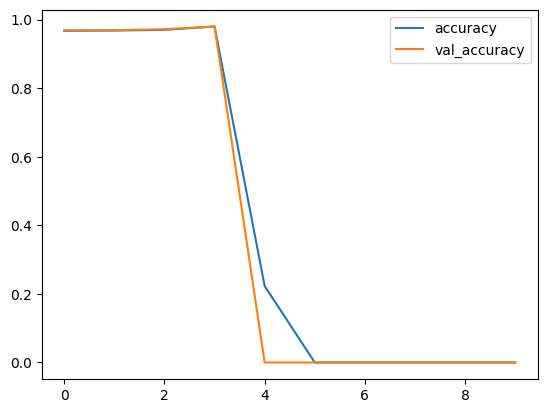

In [41]:
history = train_model(train_tokens, np.array(train_tags), model_bilstm_lstm)

# Store both training & validation metrics
results = pd.DataFrame(history.history)

# Plot training vs validation accuracy
results[['accuracy', 'val_accuracy']].plot()


In [46]:
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')
text = nlp('Hi, My name is John \n I am from Germany \n I want to work with Google  \n Steve Jobs is My Inspiration')
displacy.render(text, style = 'ent', jupyter=True)